In [24]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from ultralytics import YOLO

In [25]:
# Đọc ảnh
image_path = 'images\\bo du lieu bia so 7\\bia7 (14).bmp'
image = cv2.imread(image_path)

# Chuyển sang RGB để hiển thị bằng matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Chuyển ảnh sang grayscale để xử lý biên
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

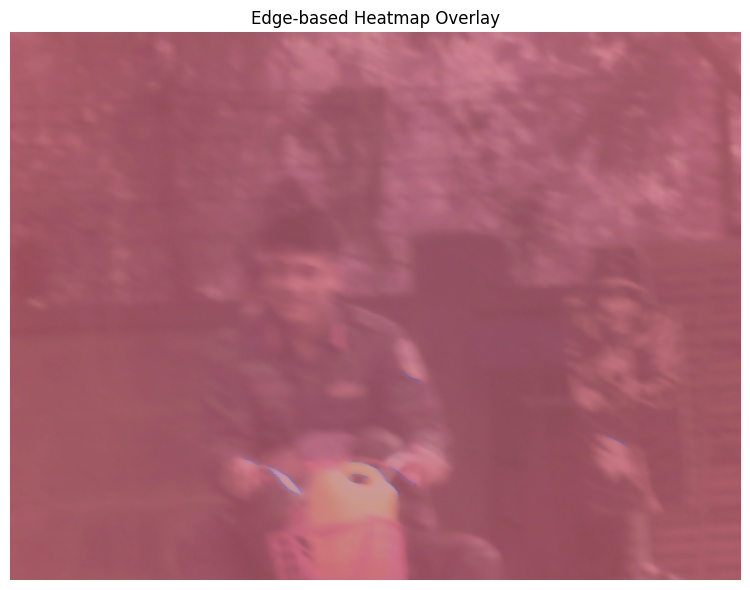

In [26]:
# Re-attempt edge-based heatmap using Canny edge detection
edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

# Apply a colormap for visualization
edges_colored = cv2.applyColorMap(edges, cv2.COLORMAP_JET)

# Overlay the edge map on the original image
overlayed_edges = cv2.addWeighted(image_rgb, 0.6, edges_colored, 0.4, 0)

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_edges)
plt.axis('off')
plt.title("Edge-based Heatmap Overlay")
plt.tight_layout()
plt.show()


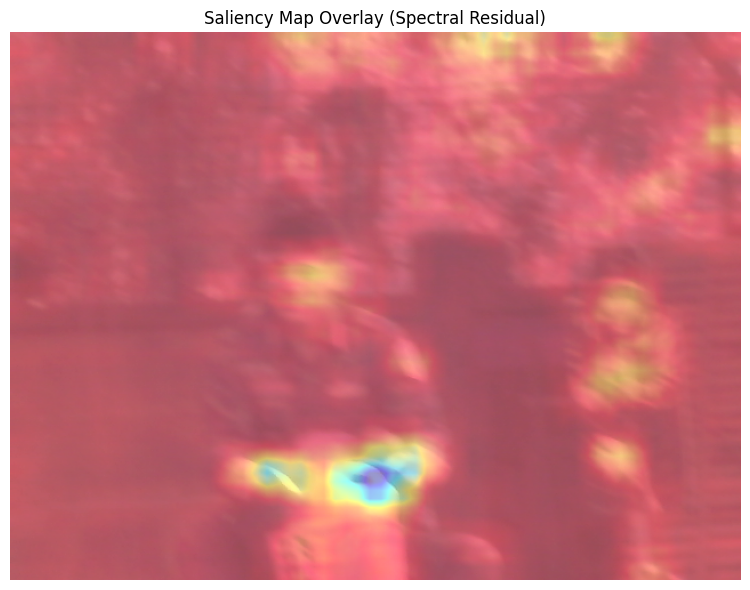

In [27]:
# Khởi tạo mô hình Saliency (Spectral Residual)
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()

# Tính toán bản đồ saliency
(success, saliency_map) = saliency.computeSaliency(image)

# Chuyển sang ảnh 8-bit để hiển thị
saliency_map_uint8 = (saliency_map * 255).astype("uint8")

# Áp dụng colormap để dễ quan sát
saliency_colored = cv2.applyColorMap(saliency_map_uint8, cv2.COLORMAP_JET)

# Chồng saliency map lên ảnh gốc
overlayed_saliency = cv2.addWeighted(image_rgb, 0.6, saliency_colored, 0.4, 0)

# Hiển thị kết quả
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_saliency)
plt.axis('off')
plt.title("Saliency Map Overlay (Spectral Residual)")
plt.tight_layout()
plt.show()

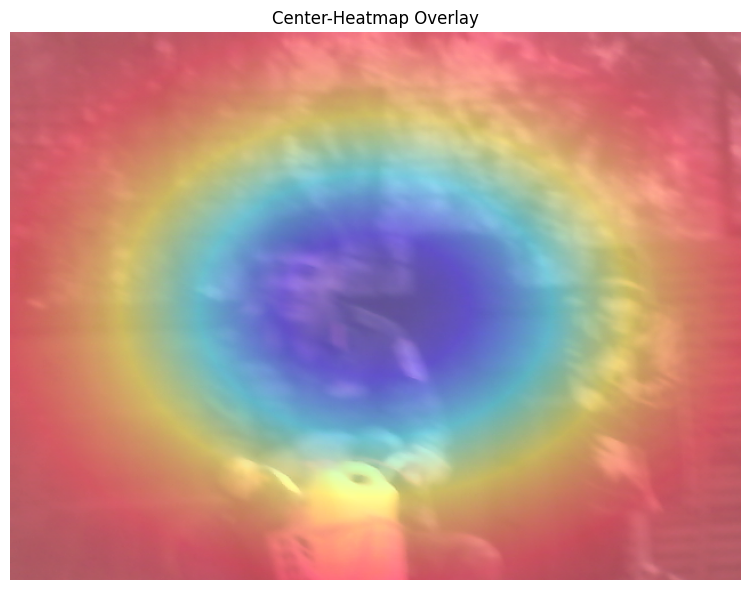

In [28]:
h, w = gray_image.shape

x = np.linspace(-1, 1, w)
y = np.linspace(-1, 1, h)
x_grid, y_grid = np.meshgrid(x, y)
d = np.sqrt(x_grid**2 + y_grid**2)
sigma, mu = 0.5, 0.0
heatmap = np.exp(-((d - mu)**2 / (2.0 * sigma**2)))

# Normalize heatmap to [0, 255] and convert to uint8
heatmap_normalized = np.uint8(255 * heatmap)

# Apply a colormap to the heatmap
heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
overlayed_image = cv2.addWeighted(image_rgb, 0.6, heatmap_colored, 0.4, 0)

# Show the result
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_image)
plt.axis('off')
plt.title("Center-Heatmap Overlay")
plt.tight_layout()
plt.show()

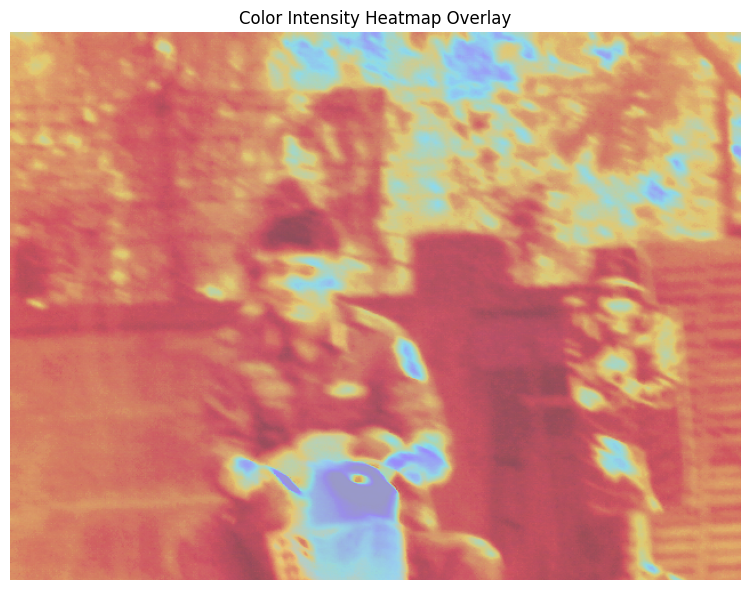

In [29]:
# Chuẩn hóa ảnh sang 0–255 nếu chưa chuẩn
intensity_map = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

# Áp dụng colormap để tạo heatmap từ độ sáng
intensity_colored = cv2.applyColorMap(intensity_map, cv2.COLORMAP_JET)

# Chồng heatmap lên ảnh gốc
overlayed_intensity = cv2.addWeighted(image_rgb, 0.6, intensity_colored, 0.4, 0)

# Hiển thị kết quả
plt.figure(figsize=(10, 6))
plt.imshow(overlayed_intensity)
plt.axis('off')
plt.title("Color Intensity Heatmap Overlay")
plt.tight_layout()
plt.show()


0: 480x640 1 person, 986.0ms
Speed: 1.9ms preprocess, 986.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


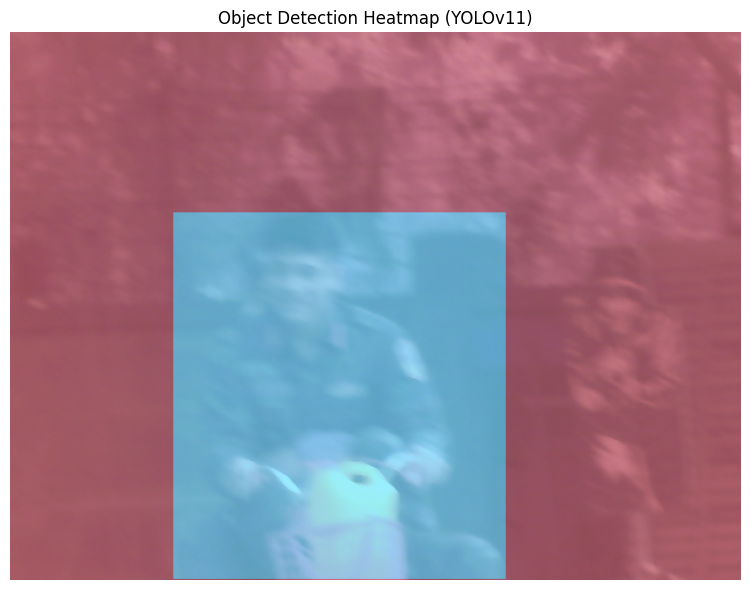

In [30]:
model_path = "yolo-models\\yolo11x.pt"
model = YOLO(model_path)

# Run inference
results = model(image_rgb)

# Parse results
heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

# Tạo heatmap từ bounding boxes
for result in results[0].boxes:
    x1, y1, x2, y2 = map(int, result.xyxy[0])  # Tọa độ hộp giới hạn thẳng đứng
    label = model.names[int(result.cls)]  # Tên nhãn
    confidence = float(result.conf)  # Chuyển Tensor sang float
    heatmap[y1:y2, x1:x2] += confidence  # tăng giá trị theo độ tin cậy

# Chuẩn hóa heatmap về 0-255
heatmap = np.clip(heatmap, 0, 1)
heatmap_uint8 = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

# Overlay heatmap lên ảnh gốc
overlay = cv2.addWeighted(image_rgb, 0.6, heatmap_color, 0.4, 0)

# Hiển thị
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Object Detection Heatmap (YOLOv11)")
plt.tight_layout()
plt.show()

# Heatmap for Template Matching
## Steps
- Perform Template Matching: Slide the template over the image to get a score for each position.
- Create the Heatmap: Use the scores to make a 2D array, then visualize it with colors.
- Overlay or Display: Show the heatmap alone or blend it with the original image.

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap_template_matching(image_path, template_path, sharpen_factor=0.7, overlay_alpha=0.5, threshold_factor=0.8):
    """
    Generate a heatmap for object detection using template matching and draw bounding boxes.

    Args:
        image_path (str): Path to the input image (e.g., 'images/bo du lieu bia so 4/bia4 (1).bmp').
        template_path (str): Path to the template image (e.g., 'images/templates/bia4.png').
        sharpen_factor (float): Factor for Laplacian sharpening applied to both image and template.
            Possible values: 0.3 to 1.0 (higher values increase sharpening intensity).
        overlay_alpha (float): Weight of the original image in the overlay (1 - overlay_alpha for heatmap).
            Possible values: 0.0 to 1.0 (0.5 means equal blending).
        threshold_factor (float): Fraction of the maximum matching score to use as threshold for multiple bounding boxes.
            Possible values: 0.5 to 0.9 (e.g., 0.8 means 80% of max score).

    Returns:
        tuple: (heatmap_resized, overlay, overlay_with_bbox) - Three images for visualization.
    """
    # Load the image and template (grayscale for simplicity)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

    # Check if images loaded correctly
    if image is None:
        raise ValueError("Failed to load image. Check file path: " + image_path)
    if template is None:
        raise ValueError("Failed to load template. Check file path: " + template_path)

    # Apply kernel-based sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    # Apply Laplacian sharpening to both image and template
    def laplacian_sharpen(img):
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        sharpened = np.clip(img - sharpen_factor * laplacian, 0, 255).astype(np.uint8)
        return sharpened

    image = laplacian_sharpen(image)
    template = laplacian_sharpen(template)

    # Apply histogram equalization
    image = cv2.equalizeHist(image)
    template = cv2.equalizeHist(template)

    # Perform template matching
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

    # Normalize the heatmap to 0-255 for visualization
    heatmap_normalized = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply a color map (e.g., hot colors: red = high confidence)
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap_colored, (image.shape[1], image.shape[0]))

    # Convert the original image to RGB for overlay
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(image_rgb, overlay_alpha, heatmap_resized, 1 - overlay_alpha, 0.0)

    # Find the best match location for bounding box
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc  # Top-left corner of the best match
    h, w = template.shape  # Template dimensions
    bottom_right = (top_left[0] + w, top_left[1] + h)  # Bottom-right corner

    # Draw bounding box on the overlay image
    bbox_color = (0, 255, 0)  # Green in BGR
    bbox_thickness = 2
    overlay_with_bbox = overlay.copy()  # Copy to avoid modifying the overlay
    cv2.rectangle(overlay_with_bbox, top_left, bottom_right, bbox_color, bbox_thickness)

    # Draw multiple bounding boxes for top matches
    threshold = threshold_factor * max_val
    locations = np.where(result >= threshold)
    for pt in zip(*locations[::-1]):  # Iterate over high-confidence locations
        top_left = pt
        bottom_right = (pt[0] + w, pt[1] + h)
        cv2.rectangle(overlay_with_bbox, top_left, bottom_right, bbox_color, bbox_thickness)

    return heatmap_resized, overlay, overlay_with_bbox


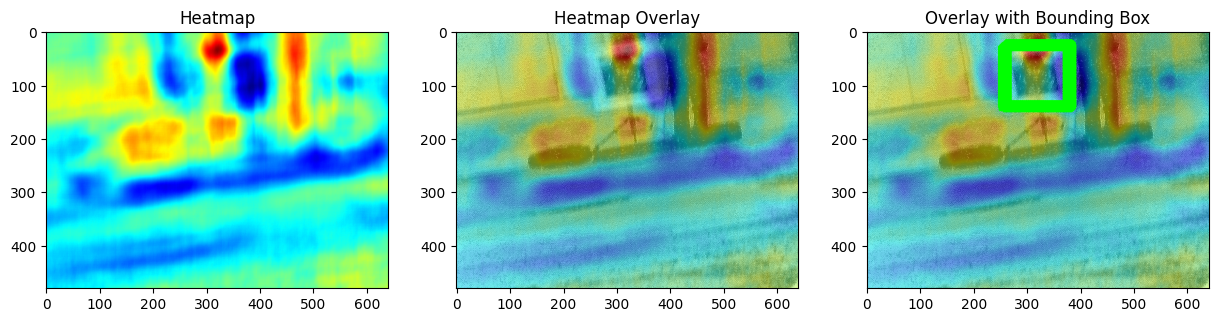

In [67]:
# Call the function with image and template paths
heatmap, overlay, overlay_with_bbox = generate_heatmap_template_matching(
    image_path='images/bo du lieu bia so 4/bia4 (2).bmp',
    template_path='images/templates/bia4.png',
    sharpen_factor=0.7,
    overlay_alpha=0.5,
    threshold_factor=0.8
)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Heatmap")
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Heatmap Overlay")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Overlay with Bounding Box")
plt.imshow(cv2.cvtColor(overlay_with_bbox, cv2.COLOR_BGR2RGB))
plt.show()

## Improve

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap_with_cartesian_box_template_matching(image_path, template_path, sharpen_factor=0.7, polar_center=None):
    """
    Perform template matching to generate a heatmap, transform to polar coordinates, and draw a bounding box
    on the original image by converting the polar box back to Cartesian coordinates.

    Args:
        image_path (str): Path to the input image (e.g., 'images/bo du lieu bia so 4/bia4 (1).bmp').
        template_path (str): Path to the template image (e.g., 'images/templates/bia4.png').
        sharpen_factor (float): Factor for Laplacian sharpening applied to both image and template.
            Possible values: 0.3 to 1.0 (higher values increase sharpening intensity).
        polar_center (tuple, optional): Center point (x, y) for polar transformation. If None, uses image center.
            Example: (image_width/2, image_height/2).

    Returns:
        tuple: (heatmap_resized, polar_heatmap, image_with_bbox) - Heatmap, polar heatmap, and original image with converted bounding box.
    """
    # Load the image and template (grayscale for simplicity)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

    # Check if images loaded correctly
    if image is None:
        raise ValueError("Failed to load image. Check file path: " + image_path)
    if template is None:
        raise ValueError("Failed to load template. Check file path: " + template_path)

    # Apply kernel-based sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    # Apply Laplacian sharpening to both image and template
    def laplacian_sharpen(img):
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        sharpened = np.clip(img - sharpen_factor * laplacian, 0, 255).astype(np.uint8)
        return sharpened

    # image = laplacian_sharpen(image)
    # template = laplacian_sharpen(template)

    # Apply histogram equalization
    image = cv2.equalizeHist(image)
    template = cv2.equalizeHist(template)

    # Perform template matching
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

    # Normalize the heatmap to 0-255 for visualization
    heatmap_normalized = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply a color map for visualization
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap_colored, (image.shape[1], image.shape[0]))

    # Convert heatmap to grayscale for polar transformation
    heatmap_gray = cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2GRAY)

    # Set the center for polar transformation (default to image center if not specified)
    if polar_center is None:
        polar_center = (image.shape[1] / 2, image.shape[0] / 2)

    # Compute the maximum radius for polar transformation
    max_radius = np.sqrt((image.shape[0] / 2) ** 2 + (image.shape[1] / 2) ** 2)

    # Transform the heatmap to polar coordinates
    polar_heatmap = cv2.linearPolar(
        heatmap_gray,
        polar_center,
        max_radius,
        cv2.WARP_FILL_OUTLIERS
    )

    # Normalize the polar heatmap for visualization
    polar_heatmap = cv2.normalize(polar_heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply a color map to the polar heatmap
    polar_heatmap_colored = cv2.applyColorMap(polar_heatmap, cv2.COLORMAP_JET)

    # Find the best match in the polar heatmap
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(polar_heatmap)

    # Define the bounding box size in polar space (arbitrary size for visualization)
    bbox_width = 50  # Width in theta (angle) direction
    bbox_height = 50  # Height in rho (radius) direction
    top_left_polar = (max_loc[0] - bbox_width // 2, max_loc[1] - bbox_height // 2)
    bottom_right_polar = (max_loc[0] + bbox_width // 2, max_loc[1] + bbox_height // 2)

    # Ensure bounding box stays within polar image bounds
    top_left_polar = (max(0, top_left_polar[0]), max(0, top_left_polar[1]))
    bottom_right_polar = (min(polar_heatmap.shape[1], bottom_right_polar[0]), min(polar_heatmap.shape[0], bottom_right_polar[1]))

    # Define the four corners of the bounding box in polar space (theta, rho)
    polar_corners = [
        (top_left_polar[0], top_left_polar[1]),         # Top-left
        (bottom_right_polar[0], top_left_polar[1]),     # Top-right
        (bottom_right_polar[0], bottom_right_polar[1]), # Bottom-right
        (top_left_polar[0], bottom_right_polar[1])      # Bottom-left
    ]

    # Convert polar coordinates (theta, rho) back to Cartesian (x, y)
    cartesian_corners = []
    for theta_pixel, rho_pixel in polar_corners:
        # Scale theta and rho based on polar image dimensions
        theta = (theta_pixel / polar_heatmap.shape[1]) * 2 * np.pi  # Theta in radians (0 to 2pi)
        rho = (rho_pixel / polar_heatmap.shape[0]) * max_radius     # Rho scaled to max_radius

        # Convert to Cartesian coordinates
        x = polar_center[0] + rho * np.cos(theta)
        y = polar_center[1] + rho * np.sin(theta)
        cartesian_corners.append([x, y])

    # Convert corners to numpy array for drawing
    cartesian_corners = np.array(cartesian_corners, dtype=np.int32).reshape((-1, 1, 2))

    # Convert the original image to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Draw the converted bounding box on the original image
    image_with_bbox = image_rgb.copy()
    cv2.drawContours(image_with_bbox, [cartesian_corners], 0, (0, 255, 0), 2)

    return heatmap_resized, polar_heatmap_colored, image_with_bbox

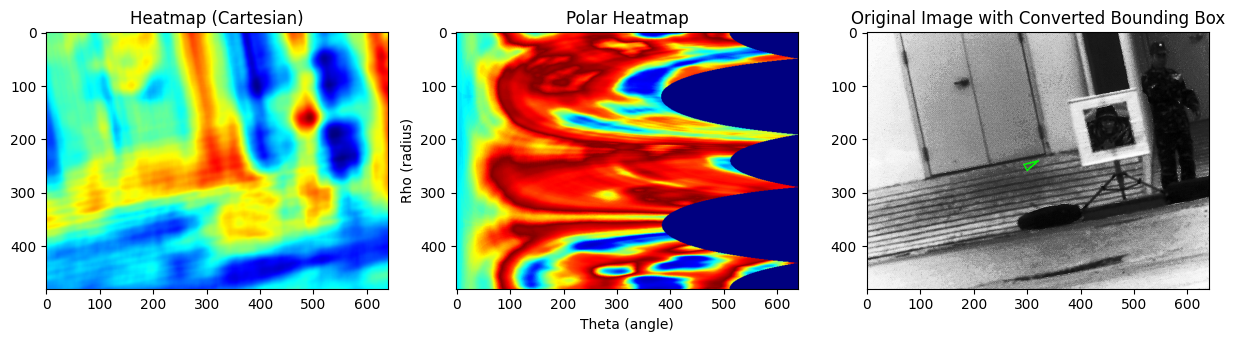

In [65]:
# Call the function with image and template paths
heatmap, polar_heatmap, image_with_bbox = generate_heatmap_with_cartesian_box_template_matching(
    image_path='images/bo du lieu bia so 4/bia4 (1).bmp',
    template_path='images/templates/bia4.png',
    sharpen_factor=0.7
)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Heatmap (Cartesian)")
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Polar Heatmap")
plt.xlabel("Theta (angle)")
plt.ylabel("Rho (radius)")
plt.imshow(cv2.cvtColor(polar_heatmap, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Original Image with Converted Bounding Box")
plt.imshow(image_with_bbox)
plt.show()

# Heatmap for Neural Network-Based Object Detection
## Steps
- Run YOLO: Use a pre-trained YOLO model to predict objects.
- Extract Heatmap: Get the model’s confidence scores or keypoint predictions.
- Visualize: Convert the scores into a colored heatmap.

In [26]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap(image_path, model_path, sharpen_factor=0.7, overlay_alpha=0.5):
    """
    Generate a heatmap for object detection using a specified YOLO model.

    Args:
        image_path (str): Path to the input image (e.g., 'image.jpg').
        model_path (str): Path to the YOLO model file (e.g., 'yolov8n.pt' for lightweight, 'yolov8x.pt' for higher accuracy).
        sharpen_factor (float): Factor for Laplacian sharpening.
            Possible values: 0.3 to 1.0 (higher values increase sharpening intensity).
        overlay_alpha (float): Weight of the original image in the overlay (1 - overlay_alpha for heatmap).
            Possible values: 0.0 to 1.0 (0.5 means equal blending).

    Returns:
        tuple: (heatmap_resized, overlay) - Two images for visualization.
    """
    # Load the YOLO model from the specified path
    model = YOLO(model_path)

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Failed to load image. Check file path: " + image_path)

    # Convert to grayscale for preprocessing
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Laplacian sharpening
    laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)
    image_gray = np.clip(image_gray - sharpen_factor * laplacian, 0, 255).astype(np.uint8)

    # Apply histogram equalization
    image_gray = cv2.equalizeHist(image_gray)

    # Convert back to BGR for YOLO inference
    image = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR)

    # Run YOLO inference
    results = model(image)

    # Create a blank heatmap
    h, w = image.shape[:2]
    heatmap_grid = np.zeros((h, w), dtype=np.float32)

    # Add confidence scores to the heatmap
    for box, conf in zip(results[0].boxes.xyxy, results[0].boxes.conf):
        x1, y1, x2, y2 = box.int().cpu().numpy()
        conf_value = conf.item()  # Convert tensor to scalar
        heatmap_grid[y1:y2, x1:x2] += conf_value

    # Normalize the heatmap to 0-255
    heatmap_normalized = cv2.normalize(heatmap_grid, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply a color map
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap_colored, (w, h))

    # Overlay the heatmap on the original image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image_rgb, overlay_alpha, heatmap_resized, 1 - overlay_alpha, 0.0)

    return heatmap_resized, overlay


<>:3: SyntaxWarning: invalid escape sequence '\y'
<>:3: SyntaxWarning: invalid escape sequence '\y'
C:\Users\cuong\AppData\Local\Temp\ipykernel_41548\1371593162.py:3: SyntaxWarning: invalid escape sequence '\y'
  model_path='yolo-models\yolo11x.pt',



0: 480x640 1 person, 618.2ms
Speed: 2.6ms preprocess, 618.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


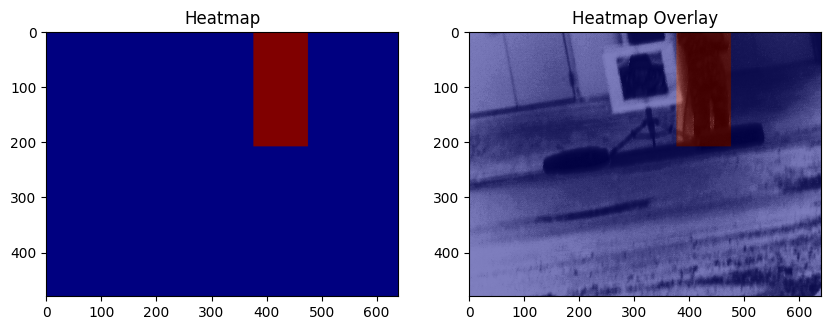

In [45]:
heatmap, overlay = generate_heatmap(
    image_path='images\\bo du lieu bia so 4\\bia4 (2).bmp',
    model_path='yolo-models\yolo11x.pt',
    sharpen_factor=0.7,
    overlay_alpha=0.5
)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Heatmap")
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Heatmap Overlay")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.show()    
    